This notebook contains the explanation of the best model (XGB classifier) as found during experiments on models *(..\notebooks\02_modeling.ipynb)*

The main goals that were set for this notebook

1. Deduce the importance of features for the model that performed best

2. Analyze the impact of features on predictions using the SHAP library.

3. Analyze the records in which the model makes mistakes




In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import joblib
import shap

from xgboost import plot_importance

Let's load our best model and data, and first apply the built-in feature importance functions *(feature_importances_)*

In [4]:
model_xgb = joblib.load('../models/model_best_xgb.joblib')

model_best_xgb = model_xgb['model']
data_processed_WOstand = model_xgb['data']

In [5]:
featire_importance = model_best_xgb.feature_importances_
feature_names = data_processed_WOstand['train_X'].columns
feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': featire_importance})
feature_importance_df.sort_values(by='importance', ascending=False).head(7)

,feature,importance
8,nr.employed,0.782903
4,emp.var.rate,0.049326
34,poutcome_success,0.019038
2,pdays,0.013205
11,economic_index,0.012853
10,employment_to_price,0.010462
5,cons.price.idx,0.009269


In [6]:
feature_importance_df_short = feature_importance_df.sort_values(by='importance', ascending=False).head(5)
feature_importance_df_short

,feature,importance
8,nr.employed,0.782903
4,emp.var.rate,0.049326
34,poutcome_success,0.019038
2,pdays,0.013205
11,economic_index,0.012853


Economic indicators showed a very strong influence, it is also worth noting that previous contacts with the client are also important indicators that affect the output of the model.

# SHAP

Let's move on to a deeper analysis of the model and see how the features affect class 1 and 0.

In [57]:
explainer = shap.TreeExplainer(model_best_xgb)

In [ ]:
shap_values = explainer(data_processed_WOstand['train_X'])  

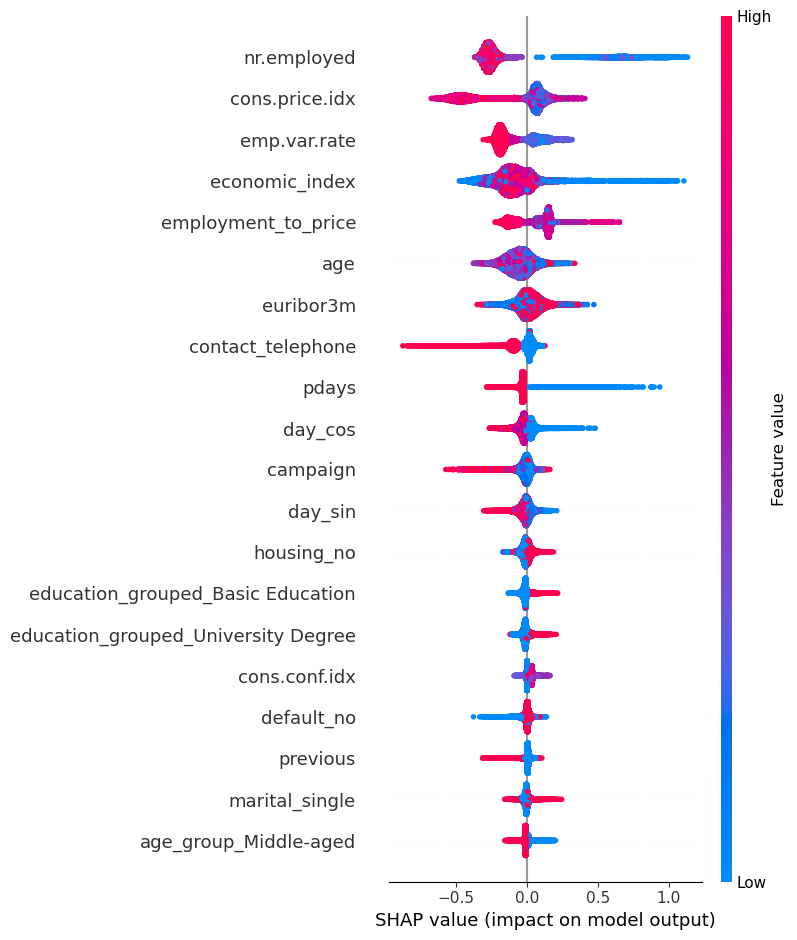

In [60]:
shap.summary_plot(shap_values.values, data_processed_WOstand['train_X'])

1. `nr.employed` - Very strongly affects our model and the smaller the value, the greater the probability of getting class 1. A similar behavior is also demonstrated by `economic_index`
2. The prediction also depends on whether there was any previous contact (`pdays`) with the client or not. If there was none (we have a high value of 999), which means on the graph that this significantly affects obtaining class 0.
3. It is also an interesting observation that more people are likely to refuse debit cards when contacted by telephone. -> It's better to use cellular


## Overall conclusion:
- nr.employed, cons.price.idx, and economic_index are the most impactful features, indicating that macroeconomic factors strongly influence deposit decisions
- Both day_cos and day_sin have moderate importance, confirming that time-based patterns contribute to predictions but are secondary to economic indicators.
- Also, according to the plot, attention should be paid to the age of the client, marital status, education

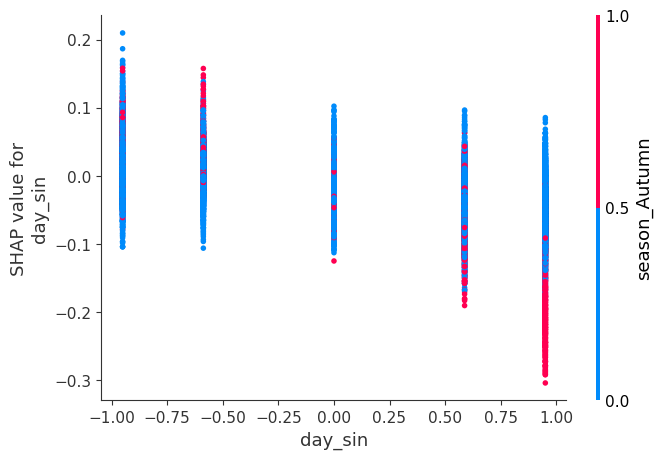

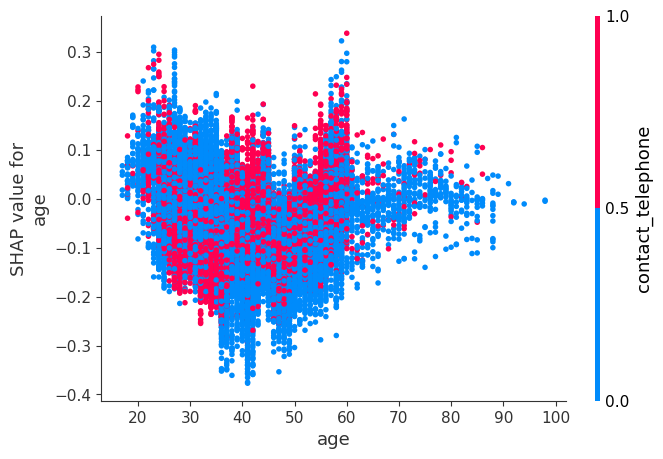

In [63]:
list = [ 'day_sin', 'age']
for i in list:  
    shap.dependence_plot(i, shap_values.values, data_processed_WOstand['train_X'])

In [43]:
df = pd.DataFrame({'day_of_week': ['mon', 'tue', 'wed', 'thu', 'fri']})
day_map = {'mon': 1, 'tue': 2, 'wed': 3, 'thu': 4, 'fri': 5}
df['day_num'] = df['day_of_week'].map(day_map)
df['day_sin'] = np.sin(2 * np.pi * df['day_num'] / 5) 
round(df, 3)

,day_of_week,day_num,day_sin
0,mon,1,0.951
1,tue,2,0.588
2,wed,3,-0.588
3,thu,4,-0.951
4,fri,5,-0.000


**Seasonality Day sin**: 
- In general, there is a dependence on the days of the week from increasing to decreasing, relative to Thursday-Wednesday-Friday-Tuesday-Monday
- The day of the week affects the classifier in such a way that Mondays (which corresponds to sine 1) are not the best day for people to contact each other, because we see low Shap values.
- We can see that in autumn (pint dots) we issue the most rejected deposits on Mondays (which corresponds to sine 1)



**Relationship between 'age', 'contact_telephone'**
- cellular = 0
- The relationship between age and its SHAP value is not linear. 
- People in the middle age (35-55) group have a decline in the graph, which means that this is the risk that the client is more likely to refuse the deposit.


# Error analysis

The final stage is error analysis to determine whether the model can be improved.

To start, let's split our validation data into three data sets - TP, TN, FP, FN

In [8]:
y_prob = model_best_xgb.predict_proba(data_processed_WOstand['val_X'])[:, 1]
threshold = 0.6
y_pred = (y_prob > threshold).astype(int)


df_results = data_processed_WOstand['val_X'].copy()
df_results['target'] = data_processed_WOstand['val_y']
df_results['prediction'] = y_pred
df_results['probability'] = y_prob


df_FP = df_results[(df_results.target != df_results.prediction) & (df_results.prediction == 1)]
df_FN = df_results[(df_results.target != df_results.prediction) & (df_results.prediction == 0)]
df_TP = df_results[(df_results.target == df_results.prediction) & (df_results.prediction == 1)]
df_TN = df_results[(df_results.target == df_results.prediction) & (df_results.prediction == 0)]

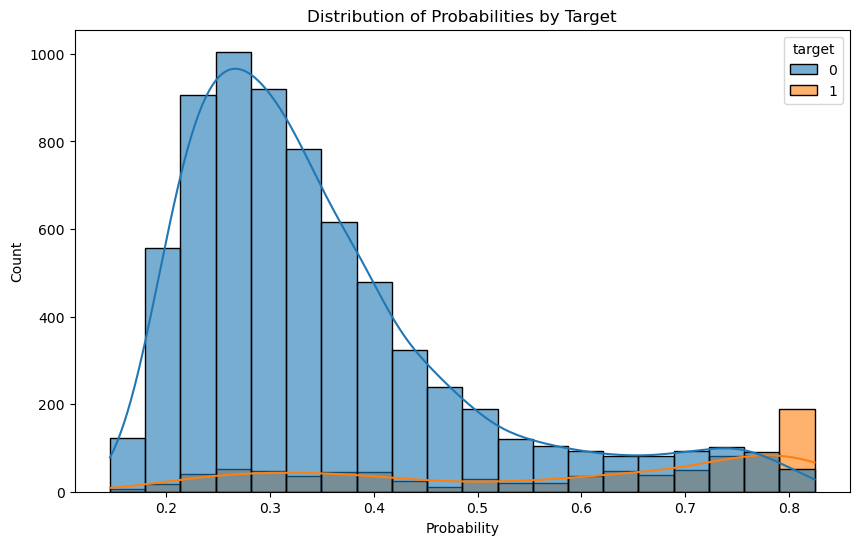

In [9]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df_results, x='probability', hue='target', kde=True,  bins=20, alpha=0.6)
plt.title('Distribution of Probabilities by Target')
plt.xlabel('Probability')
plt.ylabel('Count')
plt.show()

If we look at how the model probability outputs are distributed: 

- For class 0 - we see a peak at 0.3, and most of the data is located up to 0.5. This is a good sign that the model is not bad at recognizing class 0, but we also see another small peak around 0.75, which may indicate that the data for class 1 and 0 are very similar to each other

- The situation with class 1 is a little worse. We have a little peak at 0.8, but the distribution curve is quite uniform. 

It seems so difficult to find such a threshold to minimize FN, FP results

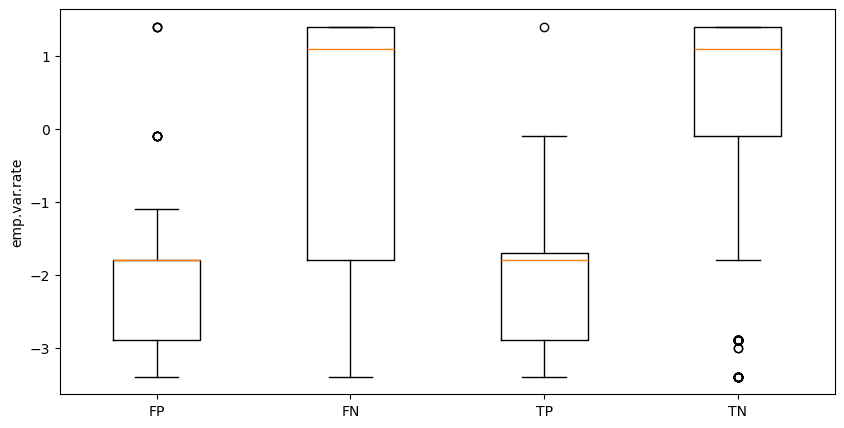

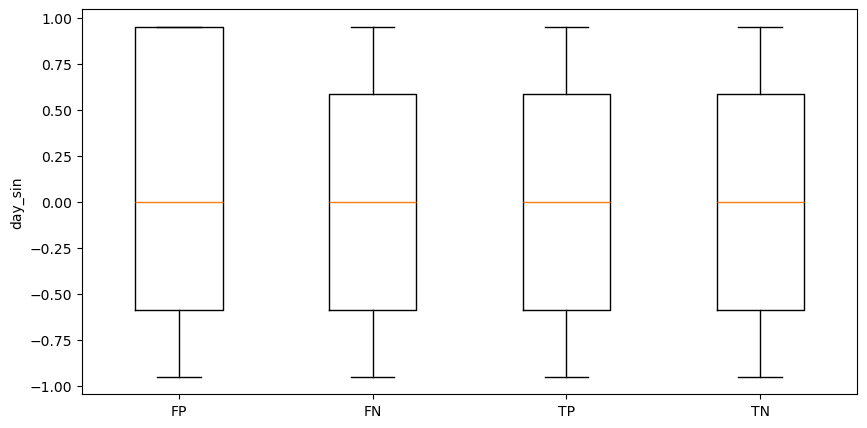

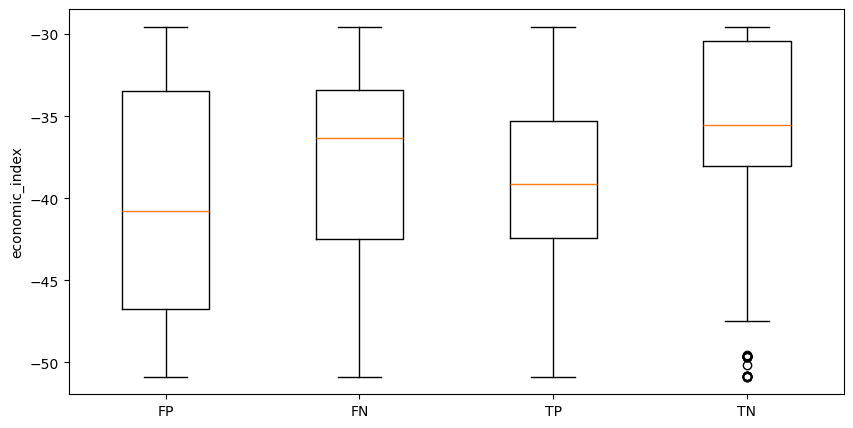

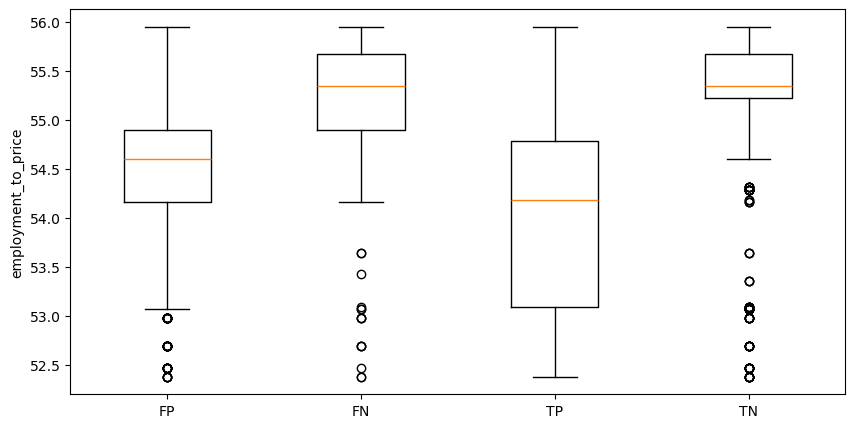

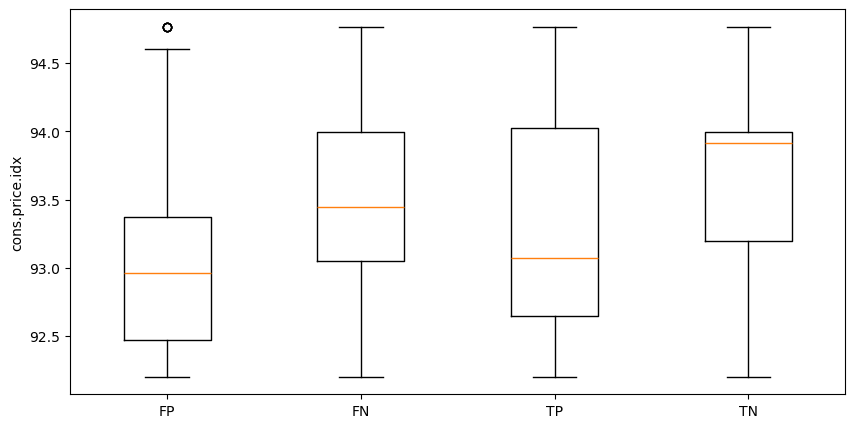

In [12]:
feature_importance_df_short = ['emp.var.rate', 'day_sin', 'economic_index', 'employment_to_price', 'cons.price.idx']

def calculate_quartiles(data):
    """Calculate quartiles for each group in the data."""
    return [np.percentile(group, [0, 25, 50, 75, 100]) for group in data]

def build_boxplots(feature, data_sets, labels):
    """Build and display boxplots for a given feature."""
    data = [df[feature] for df in data_sets]
    quartiles = calculate_quartiles(data)

    plt.figure(figsize=(10, 5))
    plt.boxplot(data)
    plt.xticks(range(1, len(labels) + 1), labels)
    plt.ylabel(feature)
    plt.show()

data_sets = [df_FP, df_FN, df_TP, df_TN]
labels = ['FP', 'FN', 'TP', 'TN']

for feature in (feature_importance_df_short):
    build_boxplots(feature, data_sets, labels)

We can generalize the behavior of changes into two types

- For these graphs we clearly see (`'emp.var.rate', 'employment_to_price'`) that TP is often confused with FP, and TN with FN (BUT at the same time, TP and TN are very clearly divided), which indicates that we have a part of the data that is very similar to each other but with different target label. It is impossible to make such a threshold to clearly separate the two classes and here we confirm that the part of people who do not take deposits is very similar to those who take them

- When the data is distributed equally among all categories `'day_sin', 'economic_index', 'cons.price.idx'`. We see that TN, TP, FN, and FP have similar data distributions and overlap very much, that they cannot be separated from each other.
    - Also `'cons.price.idx'` TN has a very high median (94) compared to other charts ( ~~ 93-93.5)

## Overall Conclusion

1. TP and FP exhibit similar distributions across most features, indicating that the current feature set lacks sufficient predictive power. 
2. To improve the models, a detailed analysis of the and feature engineering based on expert knowledge are needed. Because currently available features do not allow for clear identification of the client.
3. It may also be necessary to collect a large amount of data, because with a large imbalance and when users are similar to each other, it is difficult to clearly separate them
4. We can try to cluster users and develop separate models for each of the groups
5. It was also useful to consider additional data, such as the history of users at the current bank, provide more demographic indicators, and also gather more information about how contacts with customers were carried out.